Dava sonuçları veri setinin üzerinde karar ağacı algoritmasının gerçekleştirilip görselleştirilmesi ve sonuçların yazdırılması.

Öncelikle gerekli kütüphaneler eklenerek veri seti okunur:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("C:\\Users\\beyza\\OneDrive\\Masaüstü\\VeriBilimi\\dava_sonuclari.csv")

Veri setinde eksik değer kontrolü yapılır, eksik değer varsa sütun ortalaması ile doldurulur:

In [3]:
total_missing = df.isnull().sum().sum()
print("\nEksik değer sayısı :", total_missing)
if total_missing > 0:
    df = df.fillna(df.mean(numeric_only=True))
    print(f"{total_missing} eksik değer sütun ortalamaları ile dolduruldu.")
else:
    print("Veri setinde eksik değer yok.")


Eksik değer sayısı : 0
Veri setinde eksik değer yok.


Bu veri setinde eksik değer olmadığından düzenlemeye gerek kalmamıştır.

Aykırı değer kontrolü yapılarak aykır değer varsa silinir:

In [4]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
outlier_found = False 

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    
    if not outliers.empty:
        print(f"{col} sütununda {len(outliers)} tane aykırı değer var.")
        outlier_found = True
    df = df[(df[col] >= lower) & (df[col] <= upper)]

if not outlier_found:
    print("Veri setinde aykırı değer yok.")

Veri setinde aykırı değer yok.


Veri setinde aykırı değer bulunmamıştır.

One-hot encoding yapılır ve Outcome sütunu 0'dan oluştuğundan yeni hedef sütunu seçilir. Model train ve test verilerine ayrılarak eğitilir.

In [5]:
df = pd.get_dummies(df, columns=["Case Type"], drop_first=True)

y = df["Severity"]
X = df.drop(columns=["Severity", "Outcome"]) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = DecisionTreeClassifier(random_state=42,max_depth=7,min_samples_split=5,min_samples_leaf=3,criterion='entropy',class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Modelin accuracy,precision gibi değerleri hesaplanılarak yazdırılır:

In [6]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("\nModel Performansı:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(classification_report(y_test, y_pred, zero_division=0))


Model Performansı:
Accuracy: 0.350
Precision: 0.357
Recall: 0.350
F1-Score: 0.344
              precision    recall  f1-score   support

           1       0.44      0.29      0.35        14
           2       0.39      0.54      0.45        13
           3       0.23      0.23      0.23        13

    accuracy                           0.35        40
   macro avg       0.35      0.35      0.34        40
weighted avg       0.36      0.35      0.34        40



Karar ağacının görselleştirilmesi:

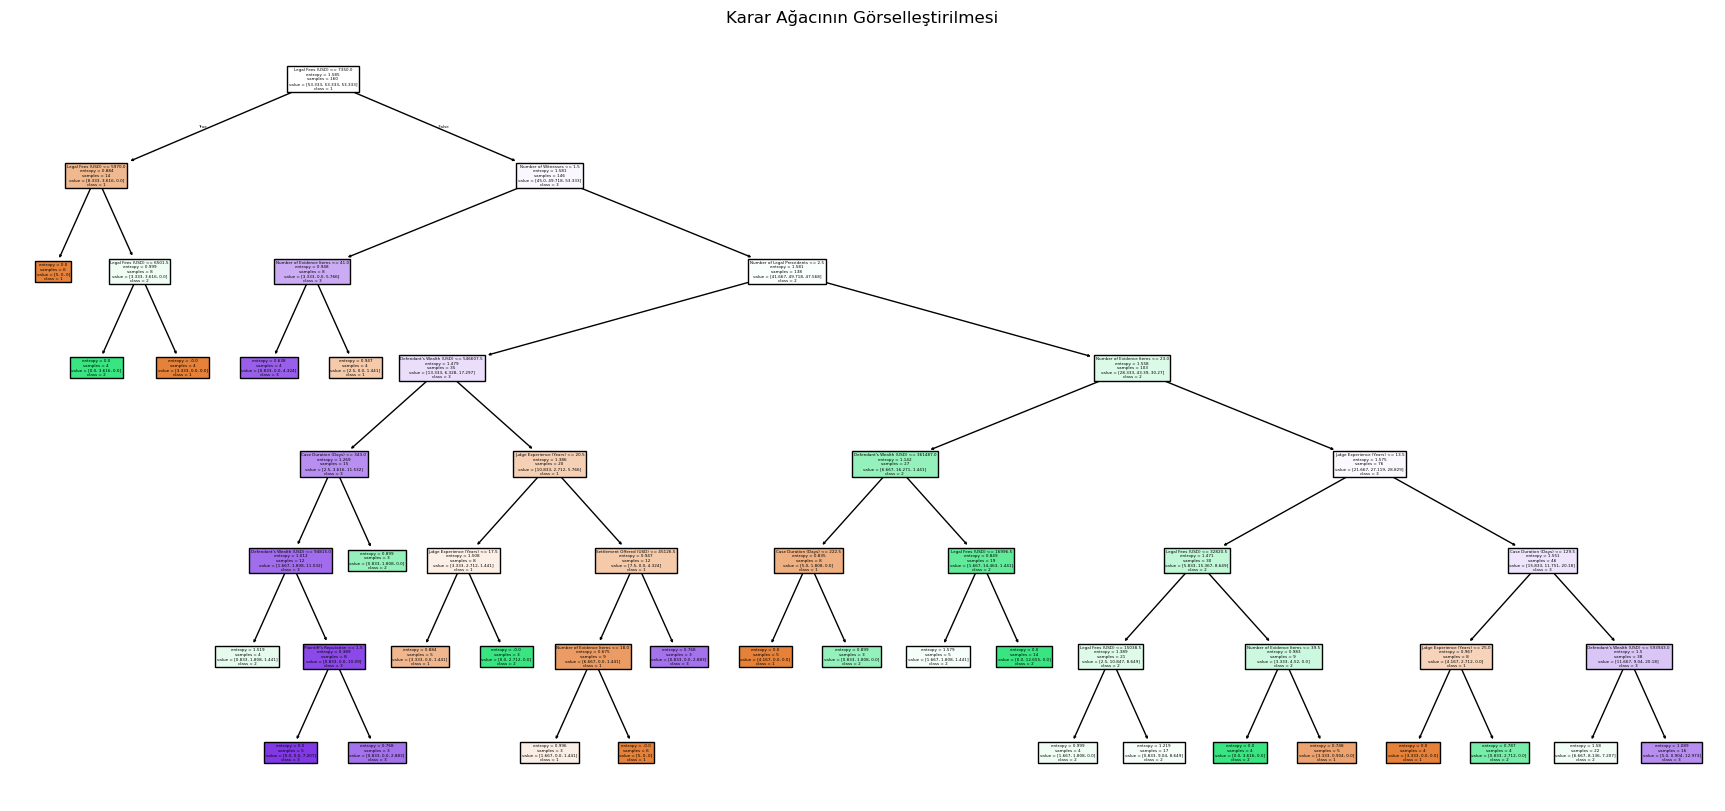

In [7]:
plt.figure(figsize=(22,10))
plot_tree(model, feature_names=X.columns, class_names=[str(c) for c in sorted(y.unique())], filled=True)
plt.title("Karar Ağacının Görselleştirilmesi")
plt.show()

Özellikler önem değerlerine göre sıralanır:

In [8]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nÖzellik önem sıralaması:")
print(importance)



Özellik önem sıralaması:
                       Feature  Importance
3             Legal Fees (USD)    0.288301
5     Defendant's Wealth (USD)    0.184165
1     Judge Experience (Years)    0.152451
6     Number of Evidence Items    0.136344
0         Case Duration (Days)    0.111583
7   Number of Legal Precedents    0.047911
2          Number of Witnesses    0.045758
8     Settlement Offered (USD)    0.022541
4       Plaintiff's Reputation    0.010946
9         Case Type_Commercial    0.000000
10          Case Type_Criminal    0.000000


Modelde en etkili özelliğin 0.288 ile "legal fees" olduğu görülmüştür. Ardından 0.18 ile defendant's wealth ve 0.152 ile judge experience gelmiştir.   Case Type_Commercial ve Case Type_Criminal ise modelde bir etki göstermemiştir.